# DSE200x Project - Analyzing the Metadata of the Current Collection of the Metropolitain Muesum of Art

We use the Metropolitain Museum of Art open access dataset that contains all metadata of its collection.
Dataset link: https://github.com/metmuseum/openaccess

All copyright has been waived by the Museum under Creative Commons Zero.

This notebook contains two main sections.

In the first we explore the data in the database and produce multiple plots that show the evolution of the current collection over time. We also separate the data per department and  produce an interactive plot with the plotly package.

In the second section we produce a predictive tools that take some metadata as inputs and predicts which department each piece belongs to for a subset of art pieces.

## Plotting the History of the Current Collection

In this section we will use the *Credit Line* data to find the acquisition date of most of the pieces, then create plots showing the history of the current collection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import string
import os

We need this initialization step to use plotly in Jupyter Notebooks.

In [2]:
py.init_notebook_mode(connected=True)

We import the raw data, display its column names and display its head.

In [3]:
raw_data = pd.read_csv("MetObjects.csv", dtype = 'str')

In [4]:
raw_data.columns

Index(['Object Number', 'Is Highlight', 'Is Public Domain', 'Object ID',
       'Department', 'Object Name', 'Title', 'Culture', 'Period', 'Dynasty',
       'Reign', 'Portfolio', 'Artist Role', 'Artist Prefix',
       'Artist Display Name', 'Artist Display Bio', 'Artist Suffix',
       'Artist Alpha Sort', 'Artist Nationality', 'Artist Begin Date',
       'Artist End Date', 'Object Date', 'Object Begin Date',
       'Object End Date', 'Medium', 'Dimensions', 'Credit Line',
       'Geography Type', 'City', 'State', 'County', 'Country', 'Region',
       'Subregion', 'Locale', 'Locus', 'Excavation', 'River', 'Classification',
       'Rights and Reproduction', 'Link Resource', 'Metadata Date',
       'Repository'],
      dtype='object')

In [5]:
raw_data.head()

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,...,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository
0,1979.486.1,False,False,1,American Decorative Arts,Coin,One-dollar Liberty Head Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/1,11/26/2018 8:00:04 AM,"Metropolitan Museum of Art, New York, NY"
1,1980.264.5,False,False,2,American Decorative Arts,Coin,Ten-dollar Liberty Head Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/2,11/26/2018 8:00:04 AM,"Metropolitan Museum of Art, New York, NY"
2,67.265.9,False,False,3,American Decorative Arts,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/3,11/26/2018 8:00:04 AM,"Metropolitan Museum of Art, New York, NY"
3,67.265.10,False,False,4,American Decorative Arts,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/4,11/26/2018 8:00:04 AM,"Metropolitan Museum of Art, New York, NY"
4,67.265.11,False,False,5,American Decorative Arts,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/5,11/26/2018 8:00:04 AM,"Metropolitan Museum of Art, New York, NY"


Example of a *Credit Line* data entry.

In [6]:
raw_data['Credit Line'][472659]

'The Elisha Whittelsey Collection, The Elisha Whittelsey Fund, 1951'

We create a list of all different departments.

In [7]:
depts = raw_data['Department'].unique().tolist()
print(depts)

['American Decorative Arts', 'European Sculpture and Decorative Arts', 'Modern and Contemporary Art', 'Arms and Armor', 'Medieval Art', 'Asian Art', 'Costume Institute', 'Islamic Art', 'Arts of Africa, Oceania, and the Americas', 'Drawings and Prints', 'Greek and Roman Art', 'Photographs', 'Ancient Near Eastern Art', 'European Paintings', 'Robert Lehman Collection', 'The Cloisters', 'Musical Instruments', 'Egyptian Art', 'The Libraries']


We create a dataframe that extracts the acquisition date if it finds a number in the last four characters of the credit line. 

We see that we obtain the acquisition year of over four fifths of the collection.

In [8]:
acq = raw_data['Credit Line'].str[-4:].str.extract('(?P<year>\d{4})').dropna().astype(int)
print(acq.shape)
print(raw_data.shape)

(399260, 1)
(472669, 43)


In [9]:
acq.head()

,year
0,1979
1,1980
2,1967
3,1967
4,1967


We create a function that filters our raw data to a single department, indexed by a number from 0 to 18.

In [10]:
def filter_dep(n):
    return raw_data[raw_data['Department'] == depts[n]]

We create a function that counts the acquisition year for a single departmnent and year as well as a function that takes a cumulative count.

In [11]:
def year_count_dept(n, yr):
    acq = filter_dep(n)['Credit Line'].str[-4:].str.extract('(?P<Year>\d{4})').dropna().astype(int)
    return (yr, len(acq[acq['Year'] == yr]))

def year_countcum_dept(n, yr):
    acq = filter_dep(n)['Credit Line'].str[-4:].str.extract('(?P<Year>\d{4})').dropna().astype(int)
    return (yr, len(acq[(acq['Year'] <= yr) & (acq['Year'] >= 1870)]))

The Libraries department have very few acquisition years in their credit lines, so we will drop them from the plots.

In [12]:
print(depts[18])
year_countcum_dept(18, 2018)

The Libraries


(2018, 55)

We create an array that has the cumulative collection count for each department.

We remove 1 from the number of rows is to exclude the Libraries.

In [13]:
acq_plot_cum = np.empty([len(depts) - 1, len(range(1870,2019))])
for i in range(0, 18):
    for yr in range(1870, 2019):
        acq_plot_cum[i, yr - 1870] = year_countcum_dept(i, yr)[1]
    

In [14]:
len(range(1870,2019))

149

In [15]:
acq_plot_cum[:18, :5]

array([[ 0.,  0.,  1.,  2., 30.],
       [ 0.,  0.,  3., 62., 63.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  4.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  2.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., 60., 62., 63., 63.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [16]:
acq_plot_cum.shape

(18, 149)

### Plots

We start with a stacked plot of all the departments (except for the Libraries).

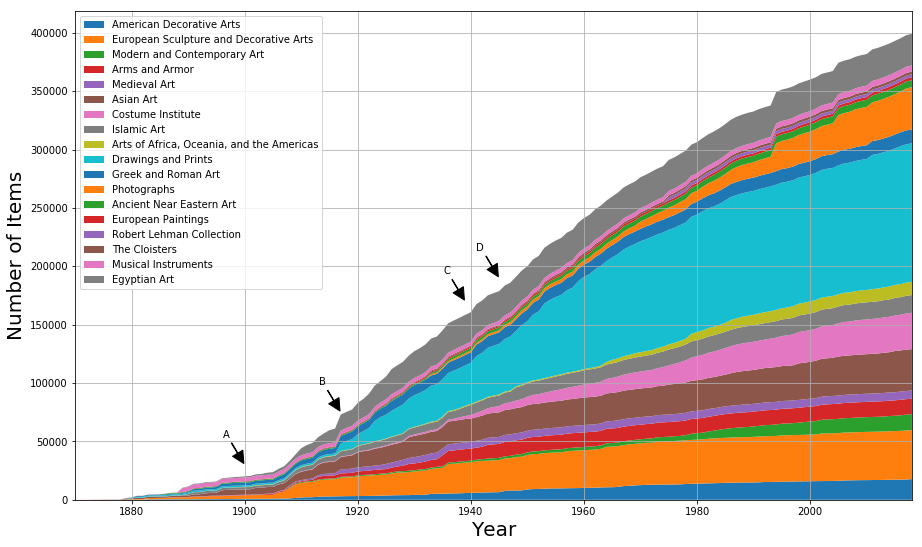

In [17]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.stackplot(list(range(1870,2019)), acq_plot_cum, labels = depts[:-1])
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of Items',fontsize=20)
ax.legend(loc='upper left')
ax.set_xlim(1870, 2018)
ax.grid(True)
ax.annotate('A',
            xy=(1900, 30000), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
            horizontalalignment='right', verticalalignment='bottom')
ax.annotate('B',
            xy=(1917, 75000), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
            horizontalalignment='right', verticalalignment='bottom')
ax.annotate('C',
            xy=(1939, 170000), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
            horizontalalignment='right', verticalalignment='bottom')
ax.annotate('D',
            xy=(1945, 190000), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5),
            horizontalalignment='right', verticalalignment='bottom')
plt.show()

We produce the same plot with plotly, which allows for more interactivity.

An online version of this plot is available here:
https://plot.ly/~lchar/1/

In [18]:
x = list(range(1870, 2019))
traces = []
for i in range(0, 18):
    traces.append(
        dict(
        x = x,
        y = acq_plot_cum[i],
        hoverinfo = 'name+x+y',
        fill = 'tonexty',
        hoveron = 'points',
        mode = 'none',
        stackgroup = 'one',
        name = depts[i]
        )
    )
    

In [19]:
layout_comp = dict(
    title='Items in the current collection per year',
    hovermode='closest',
    xaxis=dict(
        title='number of items',
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='year',
        ticklen=5,
        gridwidth=2,
    ),
    height = 600
)

In [20]:
fig = dict(data = traces, layout = layout_comp)
py.iplot(fig, filename='stacked-area-plot-hover', validate=False,)

We create a function that creates a cumulative time plot for a single department.

In [21]:
def plot_dept(n):
    fig = plt.figure(figsize=(15, 9))
    ax = plt.subplot(111)
    ax.stackplot(list(range(1870,2019)), acq_plot_cum[n,:], labels = depts[n:n+1])
    ax.set_xlabel('Year',fontsize=20)
    ax.set_ylabel('Number of Items',fontsize=20)
    ax.legend(loc='upper left')
    ax.set_xlim(1870, 2018)
    ax.grid(True)

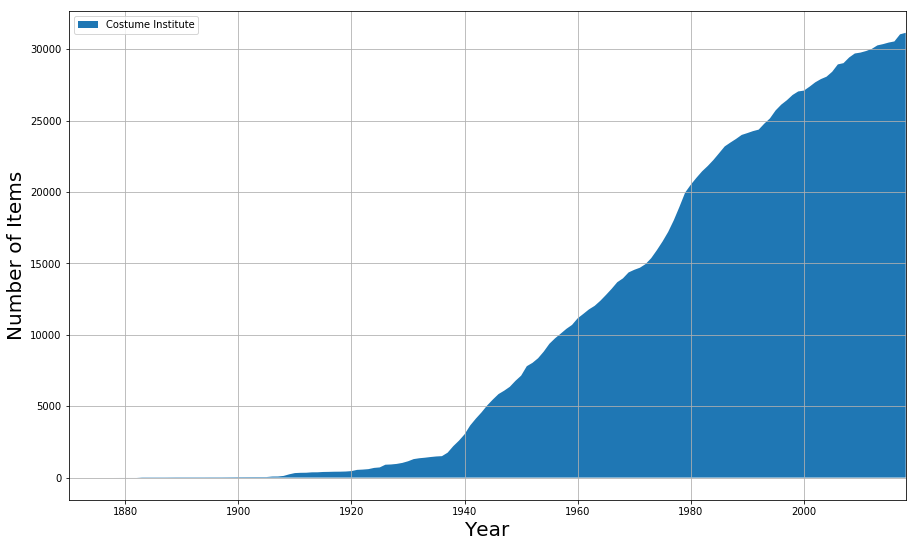

In [22]:
plot_dept(6)

Here we produce graphs with a limited year range.

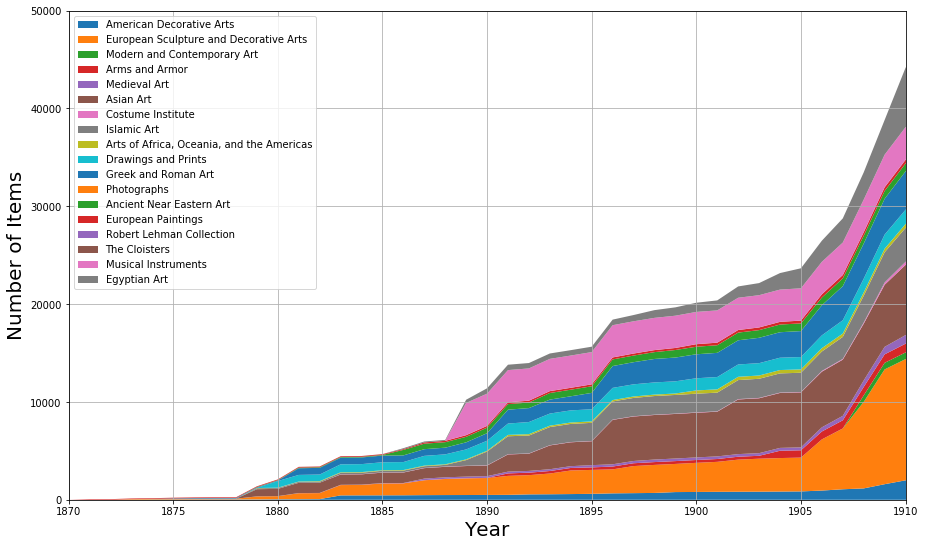

In [23]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.stackplot(list(range(1870,2019)), acq_plot_cum, labels = depts[:-1])
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of Items',fontsize=20)
ax.legend(loc='upper left')
ax.set_xlim(1870, 1910)
ax.set_ylim(0, 50000)
ax.grid(True)
plt.show()

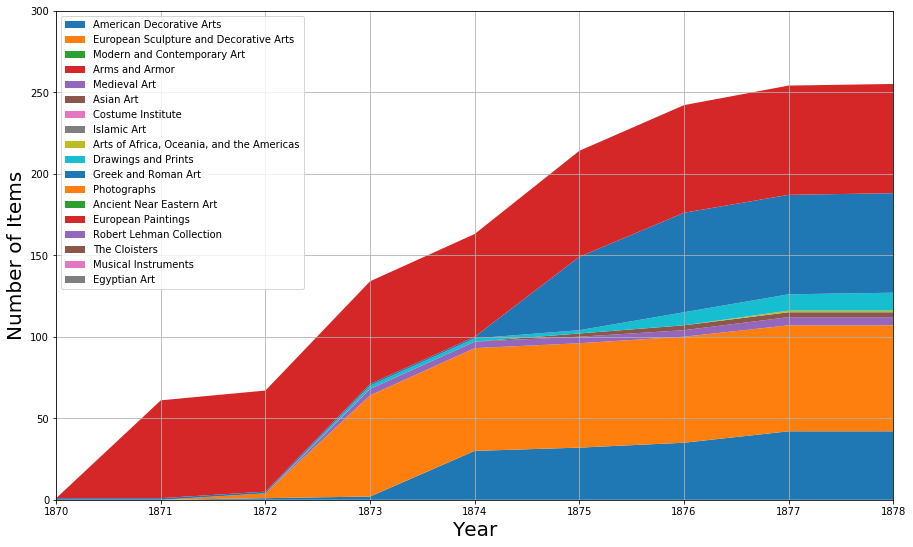

In [24]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.stackplot(list(range(1870,2019)), acq_plot_cum, labels = depts[:-1])
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of Items',fontsize=20)
ax.legend(loc='upper left')
ax.set_xlim(1870, 1878)
ax.set_ylim(0, 300)
ax.grid(True)
plt.show()

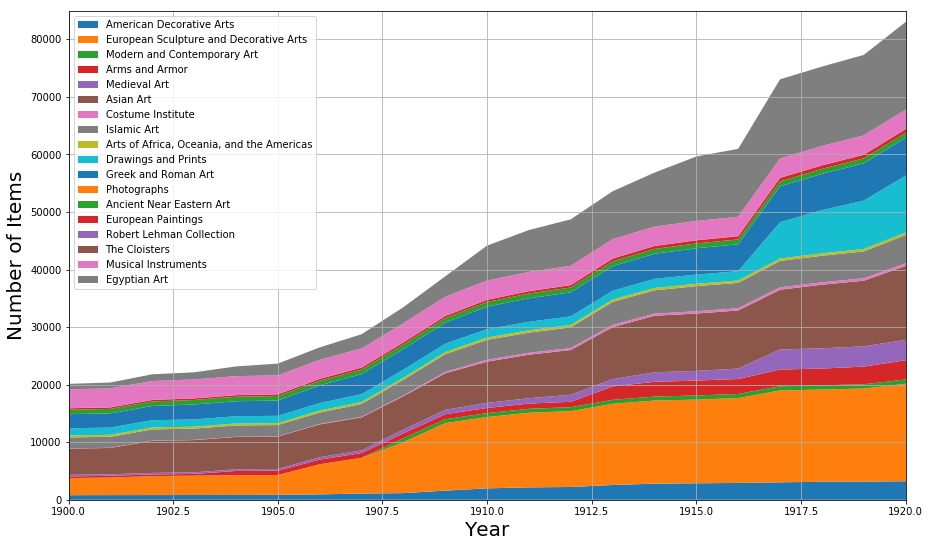

In [25]:
fig = plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
ax.stackplot(list(range(1870,2019)), acq_plot_cum, labels = depts[:-1])
ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('Number of Items',fontsize=20)
ax.legend(loc='upper left')
ax.set_xlim(1900, 1920)
ax.set_ylim(0, 85000)
ax.grid(True)
plt.show()

We create a function that creates a stacked plot of a list of department indices along with a set year range from *left* to *right*.

In [26]:
def plot_depts(l, left, right, top):
    fig = plt.figure(figsize=(15, 9))
    ax = plt.subplot(111)
    ax.stackplot(list(range(1870,2019)), acq_plot_cum.take(l, axis = 0),
                 labels = [depts[n] for n in l])
    ax.set_xlabel('Year',fontsize=20)
    ax.set_ylabel('Number of Items',fontsize=20)
    ax.legend(loc='upper left')
    ax.set_xlim(left, right)
    ax.set_ylim(0, top)
    ax.grid(True)

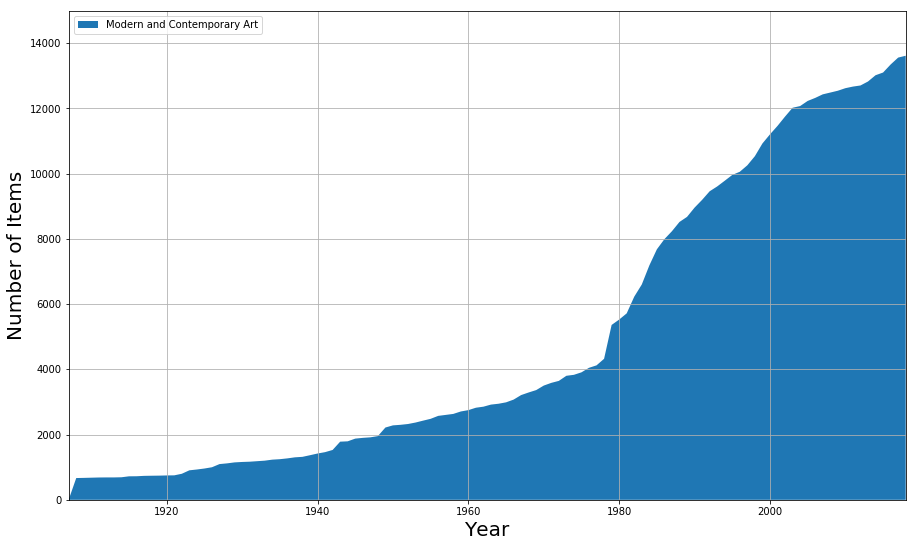

In [27]:
plot_depts([2], 1907, 2018, 15000)

## Using NLTK to predict a piece's department

In this section we will use a Naive Bayes classifier to produce a tool that should predict the department a piece belongs to given information from other columns.

In [28]:
import nltk

We choose these five departments to train the system. They all have similar size (between 27000 and 40000 items), except for *Musical Instruments*, which has only about 5300.

In [29]:
depts_list = [depts[5], depts[6], depts[11], depts[16], depts[17]]
depts_indices = [5, 6, 11, 16, 17]
print(depts_list)

['Asian Art', 'Costume Institute', 'Photographs', 'Musical Instruments', 'Egyptian Art']


These are the columns we will use to predict the department.

In [30]:
cols = ['Object Name', 'Title', 'Artist Display Name',
                       'Medium', 'Classification', 'Credit Line']

Example of a dataset slice with the six chosen columns.

In [31]:
stage = filter_dep(5)[cols]
stage.head()

,Object Name,Title,Artist Display Name,Medium,Classification,Credit Line
30651,Piece,NaN,NaN,Leather,Leatherwork,"Gift of Mr. and Mrs. H. O. Havemeyer, 1896"
30652,Panel,NaN,NaN,Paint; on leather,Leatherwork,"Gift of Mr. and Mrs. H. O. Havemeyer, 1896"
30653,Wall hanging,清 佚名 台南地區荷蘭城堡\t|Forts Zeelandia and Provinti...,Unidentified Artist,Framed wall hanging; ink and color on deerskin,Paintings,"Gift of J. Pierpont Morgan, 1909"
30654,Hanging scroll,NaN,Jin Zunnian,Hanging scroll; ink and color on silk,Paintings,"Rogers Fund, 1912"
30655,Hanging scroll,明 丁雲鵬 潯陽送客圖 軸|Song of the Lute,Ding Yunpeng,Hanging scroll; ink and color on paper,Paintings,"John Stewart Kennedy Fund, 1913"


In [32]:
stage.shape

(37320, 6)

### Generate text files with the information for each of the four departments (need to run only once)

The following function and loop takes the information, creates a file with the selected columns data on each line, unless the data is *NaN*, in which case it skips to the next column.

Each file will be placed in the appropriate department directory for use by NLTK.

In [33]:
#def write_info(dep, row):
#    f = open("nltk_data/dept_" + str(dep) + "/" + str(stage.iloc[row].name) + ".txt",
#             "w+", encoding='utf-8')
#    for col in cols:
#        if str(stage.iloc[row][col]) != 'nan': 
#            f.write(str(stage.iloc[row][col]) + "\n")
#    f.close()

In [34]:
#for dep in depts_indices:
#    os.mkdirs("nltk_data/dept_" + str(dep))
#    stage = filter_dep(dep)[cols]
#    for row in range(0, stage.shape[0]):
#        write_info(dep, row)

We create our corpus of word files

In [35]:
from nltk.corpus import PlaintextCorpusReader

# RegEx or list of file names
files = ".*\.txt"

corpus0 = PlaintextCorpusReader("nltk_data/", files, encoding = 'utf-8')
# corpus  = nltk.Text(corpus0.words())

In [36]:
corpus0.fileids()[-5:]

['dept_6/98642.txt',
 'dept_6/98643.txt',
 'dept_6/98644.txt',
 'dept_6/98645.txt',
 'dept_6/98646.txt']

### We use *defaultdict* to create a dictionary of appendable lists

This allows us to have corpus slices for each department.

In [37]:
from collections import defaultdict
dept_fileids = defaultdict(list)
for line in corpus0.fileids():
    for dep in depts_indices:
        if str(dep) in line[:7]:
            dept_fileids[dep].append(line)

In [38]:
dept_fileids[17][:5]

['dept_17/351272.txt',
 'dept_17/351273.txt',
 'dept_17/351274.txt',
 'dept_17/351275.txt',
 'dept_17/351276.txt']

The length of each department

In [39]:
(len(dept_fileids[5]), len(dept_fileids[6]),
 len(dept_fileids[11]), len(dept_fileids[16]),
 len(dept_fileids[17]))

(37320, 36729, 38870, 5316, 27919)

Number of words in our corpus.

In [40]:
len(corpus0.words())

3160004

In [41]:
corpus0.words()[:20]

['Micrograph',
 '[',
 'Microscopic',
 'view',
 'of',
 'an',
 'insect',
 ']',
 'Alois',
 'Auer',
 'Albumen',
 'silver',
 'print',
 'Photographs',
 'Rogers',
 'Fund',
 ',',
 '1918',
 'Photograph',
 'Nightview']

We add useless words and filter them our of our corpus.

In [42]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
# useless_words

In [43]:
filtered_words = [word for word in corpus0.words() if not word in useless_words]
len(filtered_words)

2243602

This function creates bag of filtered words from a corpus.

In [44]:
def build_bag_of_words_features_filtered(words):
    return {
        word:1 for word in words \
        if not word in useless_words}

We create a dictionary of bags for each department using the department index as key.

In [45]:
dep_features = {
    dep: 
    [
        (build_bag_of_words_features_filtered(corpus0.words(fileids=[f])), depts[dep]) \
        for f in dept_fileids[dep]
    ]
    for dep in depts_indices
}

In [46]:
print(dep_features[5][:5])

[({'Piece': 1, 'Leather': 1, 'Leatherwork': 1, 'Gift': 1, 'Mr': 1, 'Mrs': 1, 'H': 1, 'O': 1, 'Havemeyer': 1, '1896': 1}, 'Asian Art'), ({'Panel': 1, 'Paint': 1, 'leather': 1, 'Leatherwork': 1, 'Gift': 1, 'Mr': 1, 'Mrs': 1, 'H': 1, 'O': 1, 'Havemeyer': 1, '1896': 1}, 'Asian Art'), ({'Wall': 1, 'hanging': 1, '清': 1, '佚名': 1, '台南地區荷蘭城堡': 1, 'Forts': 1, 'Zeelandia': 1, 'Provintia': 1, 'City': 1, 'Tainan': 1, 'Unidentified': 1, 'Artist': 1, 'Framed': 1, 'wall': 1, 'ink': 1, 'color': 1, 'deerskin': 1, 'Paintings': 1, 'Gift': 1, 'J': 1, 'Pierpont': 1, 'Morgan': 1, '1909': 1}, 'Asian Art'), ({'Hanging': 1, 'scroll': 1, 'Jin': 1, 'Zunnian': 1, 'ink': 1, 'color': 1, 'silk': 1, 'Paintings': 1, 'Rogers': 1, 'Fund': 1, '1912': 1}, 'Asian Art'), ({'Hanging': 1, 'scroll': 1, '明': 1, '丁雲鵬': 1, '潯陽送客圖': 1, '軸': 1, 'Song': 1, 'Lute': 1, 'Ding': 1, 'Yunpeng': 1, 'ink': 1, 'color': 1, 'paper': 1, 'Paintings': 1, 'John': 1, 'Stewart': 1, 'Kennedy': 1, 'Fund': 1, '1913': 1}, 'Asian Art')]


We use the Naive Bayes Classifier

In [47]:
from nltk.classify import NaiveBayesClassifier

We split the training sets to the testing sets by keeping the first 80% of the items for the training set.

In [48]:
split = {dep: int(np.ceil(0.8*len(dept_fileids[dep]))) for dep in depts_indices}
split

{5: 29856, 6: 29384, 11: 31096, 16: 4253, 17: 22336}

We group all training sets and all test sets together

In [49]:
train_set = []
test_set = []
for dep in depts_indices:
    train_set = train_set + dep_features[dep][:split[dep]]
    test_set = test_set + dep_features[dep][split[dep]:]

In [50]:
train_set[:2]

[({'Piece': 1,
   'Leather': 1,
   'Leatherwork': 1,
   'Gift': 1,
   'Mr': 1,
   'Mrs': 1,
   'H': 1,
   'O': 1,
   'Havemeyer': 1,
   '1896': 1},
  'Asian Art'),
 ({'Panel': 1,
   'Paint': 1,
   'leather': 1,
   'Leatherwork': 1,
   'Gift': 1,
   'Mr': 1,
   'Mrs': 1,
   'H': 1,
   'O': 1,
   'Havemeyer': 1,
   '1896': 1},
  'Asian Art')]

We perform a classification, then verify the accuracy of the predictor.

We observe that the accuracy overall is higher than 97%, but the musical instrument department (index 16) only has an accuracy of about 84%. This is probably due to the imbalance in the data sets. There are significantly fewer musical instruments than any of the other four categories of items, which affects the probabilities of the algorithm.

In [51]:
dept_classifier = NaiveBayesClassifier.train(train_set)

In [52]:
nltk.classify.util.accuracy(dept_classifier, train_set)*100

95.19606585418003

In [53]:
nltk.classify.util.accuracy(dept_classifier, test_set)*100

97.53669301036642

In [54]:
dep_test = 16
nltk.classify.util.accuracy(dept_classifier, dep_features[dep_test][split[dep_test]:])*100

83.81937911571026

An overview of the most useful features. The most informative feature is the year 1889, when about half of the musical instruments were obtained. The next few features directly reference the name of the department.

In [55]:
dept_classifier.show_most_informative_features()

Most Informative Features
                    1889 = 1              Musica : Photog =  14028.0 : 1.0
                   print = 1              Photog : Costum =  13668.7 : 1.0
             Instruments = 1              Musica : Asian  =  13398.5 : 1.0
                 Musical = 1              Musica : Egypti =  10083.3 : 1.0
             Photographs = 1              Photog : Costum =   8572.4 : 1.0
                  Walker = 1              Photog : Egypti =   5261.1 : 1.0
                  Crosby = 1              Musica : Photog =   4674.4 : 1.0
                    silk = 1              Costum : Photog =   3921.3 : 1.0
                  cotton = 1              Costum : Photog =   3428.4 : 1.0
                negative = 1              Photog : Egypti =   3336.8 : 1.0


To get a more accurate predictor, it might be a better idea to have categories of similar sizes, so we start again without the musical instruments.

In [56]:
depts_indices_2 = depts_indices[:3]+depts_indices[-1:]
depts_indices_2

[5, 6, 11, 17]

We group the training sets and test sets together.

In [57]:
train_set_2 = []
test_set_2 = []
for dep in depts_indices_2:
    train_set_2 = train_set_2 + dep_features[dep][:split[dep]]
    test_set_2 = test_set_2 + dep_features[dep][split[dep]:]

In [58]:
train_set_2[:2]

[({'Piece': 1,
   'Leather': 1,
   'Leatherwork': 1,
   'Gift': 1,
   'Mr': 1,
   'Mrs': 1,
   'H': 1,
   'O': 1,
   'Havemeyer': 1,
   '1896': 1},
  'Asian Art'),
 ({'Panel': 1,
   'Paint': 1,
   'leather': 1,
   'Leatherwork': 1,
   'Gift': 1,
   'Mr': 1,
   'Mrs': 1,
   'H': 1,
   'O': 1,
   'Havemeyer': 1,
   '1896': 1},
  'Asian Art')]

We train the classifier and check its accuracy. We see that the accuracy overall is much higher. The most inaccurate department is *Asian Art* at about 94%, which is still quite good. Overall accuracy is about 98%.

In [59]:
dept_classifier_2 = NaiveBayesClassifier.train(train_set_2)

In [60]:
nltk.classify.util.accuracy(dept_classifier_2, train_set_2)*100

99.60948594149389

In [61]:
nltk.classify.util.accuracy(dept_classifier_2, test_set_2)*100

98.07924447915927

In [62]:
dep_test = 5
nltk.classify.util.accuracy(dept_classifier_2, dep_features[dep_test][split[dep_test]:])*100

94.2524115755627

We display more informative features. We see that the medium of the piece seems like a good indicator of its department.

In [63]:
dept_classifier_2.show_most_informative_features(20)

Most Informative Features
                   print = 1              Photog : Costum =  13668.7 : 1.0
             Photographs = 1              Photog : Costum =   8572.4 : 1.0
                  Walker = 1              Photog : Egypti =   5261.1 : 1.0
                    silk = 1              Costum : Photog =   3921.3 : 1.0
                  cotton = 1              Costum : Photog =   3428.4 : 1.0
                negative = 1              Photog : Egypti =   3336.8 : 1.0
                Ceramics = 1              Asian  : Egypti =   3017.2 : 1.0
                 Pottery = 1              Egypti : Photog =   2610.3 : 1.0
                  Scarab = 1              Egypti : Asian  =   2531.2 : 1.0
              Polychrome = 1              Asian  : Photog =   2512.5 : 1.0
               Havemeyer = 1              Asian  : Photog =   2482.0 : 1.0
                    1889 = 1              Costum : Photog =   2325.0 : 1.0
                 leather = 1              Costum : Photog =   2320.1 : 1.0

### Try shuffling the department lists

There might be ordering issues with the classification features, such as a feature heavily present in the last 20% of the lists (a big donation from a single donor for example), so we will shuffle the features lists before splitting the train and test sets.

In [64]:
from random import shuffle

In [65]:
depts_indices_3 = depts_indices[:3]+depts_indices[-1:]
depts_indices_3

[5, 6, 11, 17]

We group the training sets and test sets together. Here we create a copy of the features dictionary and shuffle its output lists before grouping them.

In [66]:
train_set_3 = []
test_set_3 = []
dep_features_rand = dep_features.copy()
for dep in depts_indices_3:
    shuffle(dep_features_rand[dep])
    train_set_3 = train_set_3 + dep_features_rand[dep][:split[dep]]
    test_set_3 = test_set_3 + dep_features_rand[dep][split[dep]:]

In [67]:
train_set_3[:2]

[({'Dish': 1,
   'Porcelain': 1,
   'painted': 1,
   'cobalt': 1,
   'blue': 1,
   'transparent': 1,
   'glaze': 1,
   'Jingdezhen': 1,
   'ware': 1,
   'Ceramics': 1,
   'Gift': 1,
   'Mrs': 1,
   'Richard': 1,
   'E': 1,
   'Linburn': 1,
   'memory': 1,
   '1975': 1},
  'Asian Art'),
 ({'Piece': 1,
   'Silk': 1,
   'Compound': 1,
   'weave': 1,
   'Textiles': 1,
   'Woven': 1,
   'Gift': 1,
   'Kihei': 1,
   'Hattori': 1,
   'memory': 1,
   'father': 1,
   '1920': 1},
  'Asian Art')]

We train the classifier and check its accuracy. We see that the accuracy overall is even higher. The most inaccurate department is *Asian Art* at above 98.6%, which is still quite good. Overall accuracy is about 99.3%.

In [68]:
dept_classifier_3 = NaiveBayesClassifier.train(train_set_3)

In [69]:
nltk.classify.util.accuracy(dept_classifier_3, train_set_3)*100

99.46481823345641

In [70]:
nltk.classify.util.accuracy(dept_classifier_3, test_set_3)*100

99.32897820066748

In [71]:
dep_test = 5
nltk.classify.util.accuracy(dept_classifier_3, dep_features[dep_test][split[dep_test]:])*100

98.47266881028939

We display more informative features. We see that the medium of the piece seems like a good indicator of its department.

In [72]:
dept_classifier_3.show_most_informative_features(20)

Most Informative Features
                   print = 1              Photog : Costum =  14129.8 : 1.0
             Photographs = 1              Photog : Costum =   8953.7 : 1.0
                 Gelatin = 1              Photog : Asian  =   5292.5 : 1.0
                negative = 1              Photog : Egypti =   5203.6 : 1.0
                    silk = 1              Costum : Photog =   3877.3 : 1.0
                 Costume = 1              Costum : Egypti =   3512.7 : 1.0
            Metropolitan = 1              Costum : Egypti =   3245.1 : 1.0
                  cotton = 1              Costum : Photog =   3151.9 : 1.0
                  Walker = 1              Photog : Egypti =   2567.4 : 1.0
                Ceramics = 1              Asian  : Egypti =   2552.9 : 1.0
                fragment = 1              Egypti : Photog =   2353.2 : 1.0
                   Woven = 1              Asian  : Costum =   2277.7 : 1.0
              Polychrome = 1              Asian  : Photog =   2140.3 : 1.0

Let's try adding back the musical instruments

In [73]:
depts_indices_4 = depts_indices
depts_indices_4

[5, 6, 11, 16, 17]

We group the training sets and test sets together. Here we create a copy of the features dictionary and shuffle its output lists before grouping them.

In [74]:
train_set_4 = []
test_set_4 = []
dep_features_rand = dep_features.copy()
for dep in depts_indices_4:
    shuffle(dep_features_rand[dep])
    train_set_4 = train_set_4 + dep_features_rand[dep][:split[dep]]
    test_set_4 = test_set_4 + dep_features_rand[dep][split[dep]:]

In [75]:
train_set_4[:2]

[({'Box': 1,
   'Gold': 1,
   'maki': 1,
   'e': 1,
   'black': 1,
   'lacquer': 1,
   'Lacquer': 1,
   'Gift': 1,
   'Mrs': 1,
   'George': 1,
   'A': 1,
   'Crocker': 1,
   'Elizabeth': 1,
   'Masten': 1,
   '),': 1,
   '1937': 1},
  'Asian Art'),
 ({'Hanging': 1,
   'scroll': 1,
   'Kawamata': 1,
   'Tsunemasa': 1,
   'ink': 1,
   'color': 1,
   'gold': 1,
   'silk': 1,
   'Paintings': 1,
   'The': 1,
   'Howard': 1,
   'Mansfield': 1,
   'Collection': 1,
   'Purchase': 1,
   'Rogers': 1,
   'Fund': 1,
   '1936': 1},
  'Asian Art')]

We train the classifier and check its accuracy. We see that the accuracy overall went down. The most inaccurate department is *Costume Institute* at about 84.5%, which is a considerable drop in accuracy. Overall accuracy is about 95.6%.

In [76]:
dept_classifier_4 = NaiveBayesClassifier.train(train_set_4)

In [77]:
nltk.classify.util.accuracy(dept_classifier_4, train_set_4)*100

95.82638443446653

In [78]:
nltk.classify.util.accuracy(dept_classifier_4, test_set_4)*100

95.72342536521947

In [79]:
dep_test = 6
print(depts[dep_test])
nltk.classify.util.accuracy(dept_classifier_4, dep_features[dep_test][split[dep_test]:])*100

Costume Institute


85.05105513955071

We display more informative features. We see that the medium of the piece seems like a good indicator of its department.

In [80]:
dept_classifier_4.show_most_informative_features(20)

Most Informative Features
                   print = 1              Photog : Costum =  14114.0 : 1.0
             Instruments = 1              Musica : Asian  =  12467.3 : 1.0
                 Musical = 1              Musica : Egypti =   9369.2 : 1.0
             Photographs = 1              Photog : Costum =   8943.5 : 1.0
                    1889 = 1              Musica : Photog =   7735.5 : 1.0
                    silk = 1              Costum : Photog =   6519.2 : 1.0
                  Crosby = 1              Musica : Photog =   5588.0 : 1.0
                 Gelatin = 1              Photog : Asian  =   5285.5 : 1.0
                Brooklyn = 1              Costum : Asian  =   4319.3 : 1.0
                 Faience = 1              Egypti : Photog =   3876.3 : 1.0
                 Costume = 1              Costum : Egypti =   3502.0 : 1.0
                Textiles = 1              Asian  : Photog =   3449.9 : 1.0
            Metropolitan = 1              Costum : Egypti =   3236.0 : 1.0

In [ ]:
dept_classifier_4 = NaiveBayesClassifier.train(train_set_4)